In [94]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

In [95]:
import warnings 
warnings.filterwarnings("ignore")

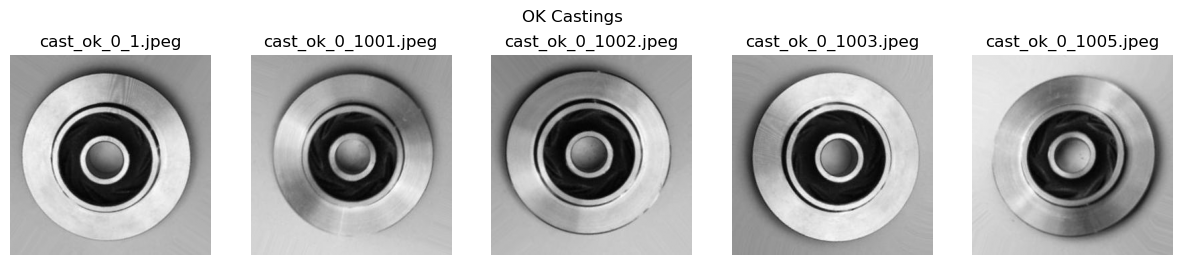

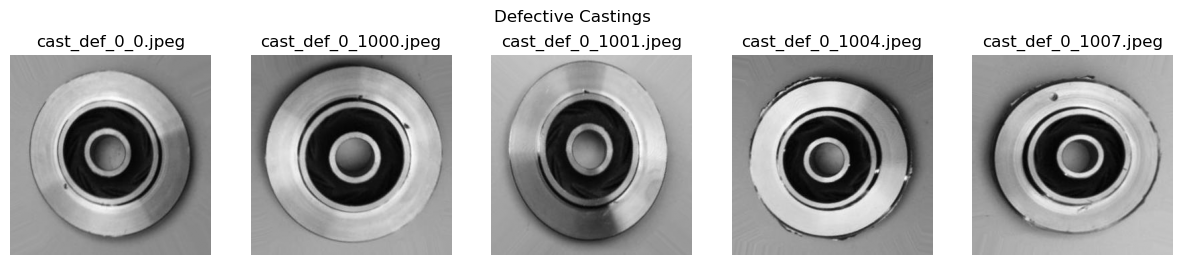

In [96]:
def plot_sample_images(folder, title):
    images = os.listdir(folder)[:5]
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, img_name in enumerate(images):
        img = Image.open(os.path.join(folder, img_name)).convert('L')
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(img_name)
    plt.suptitle(title)
    plt.show()

plot_sample_images(r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\train\ok_front", 'OK Castings')
plot_sample_images(r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\train\def_front", 'Defective Castings')

## Binary classification of the model

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(128, 128, 1)),  # ✅ Use shape instead of batch_shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

## model training

In [98]:
train_dr = r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\train"

In [99]:
train_dr

'C:\\Users\\SANDEEP\\Downloads\\ML_EXAm\\casting_data\\train'

In [100]:
test_dr = r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\test"

In [101]:
test_dr

'C:\\Users\\SANDEEP\\Downloads\\ML_EXAm\\casting_data\\test'

In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dr,
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True
)

test_gen = datagen.flow_from_directory(
    test_dr,
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## train the model

In [104]:
model = build_cnn()
model.fit(train_gen, validation_data=test_gen, epochs=10)

Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 47s 213ms/step - accuracy: 0.7446 - loss: 0.4971 - val_accuracy: 0.8685 - val_loss: 0.3055
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 212ms/step - accuracy: 0.9278 - loss: 0.1948 - val_accuracy: 0.9413 - val_loss: 0.1569
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.9625 - loss: 0.1112 - val_accuracy: 0.9832 - val_loss: 0.0572
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.9852 - loss: 0.0565 - val_accuracy: 0.9846 - val_loss: 0.0481
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 210ms/step - accuracy: 0.9899 - loss: 0.0365 - val_accuracy: 0.9958 - val_loss: 0.0268
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.9926 - loss: 0.0318 - val_accuracy: 0.9930 - val_loss: 0.0224
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 209ms/step - accuracy: 0.9917 - loss: 0.0284 - val_accuracy: 0.9832 - val_loss: 0.0418
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 45s 215ms/step - accuracy: 0.9950 - loss: 0

## Clustering Defect Types (K-Means)

### feature extraction for clustering

In [105]:
feature_model = models.Model(inputs=model.input, outputs=model.get_layer(index=-2).output)

# Get features from a batch of images
features = feature_model.predict(train_gen[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


## k-means clustering

In [106]:
from sklearn.cluster import KMeans

In [107]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(features)

KMeans(n_clusters=6, random_state=42)

In [108]:
cluster_labels = kmeans.predict(features)

In [109]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

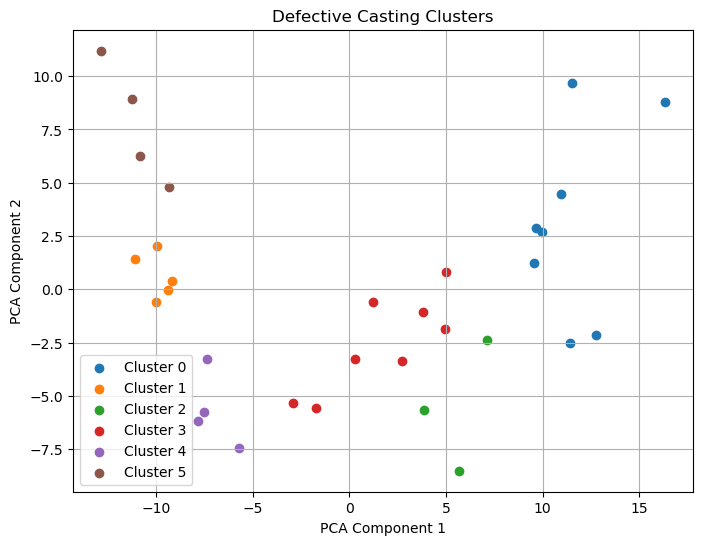

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.scatter(
        reduced_features[cluster_labels == i, 0],
        reduced_features[cluster_labels == i, 1],
        label=f"Cluster {i}"
    )
plt.title("Defective Casting Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [111]:
defect_types = ['Gas Porosity', 'Shrinkage', 'Metallurgical', 'Mold', 'Pouring', 'Shape']
label=f"{defect_types[i]}"

## save models 

In [128]:



model.save("cnn_model.keras")  # recommended new format



import joblib
joblib.dump(kmeans, "kmeans_model.pkl")

['kmeans_model.pkl']

In [129]:
model = tf.keras.models.load_model("cnn_model.keras")


## Grad- CAM Heatmap

In [132]:
import cv2
import tensorflow.keras.backend as K

def generate_gradcam(model, img_array, layer_name='conv2d_3'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (128, 128))
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()
    return heatmap

## load test image for grad-cam

In [133]:
from PIL import Image

# Load and preprocess image
img_path = r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\test\def_front\cast_def_0_65.jpeg" # replace with actual image path
img = Image.open(img_path).convert('L').resize((128, 128))
img_array = np.array(img).reshape(1, 128, 128, 1) / 255.0

## Generate Grad-CAM Heatmap

In [134]:
import tensorflow as tf
from tensorflow.keras import layers, models

heatmap = generate_gradcam(model, img_array, layer_name='conv2d_9')

## Visualize the Heatmap

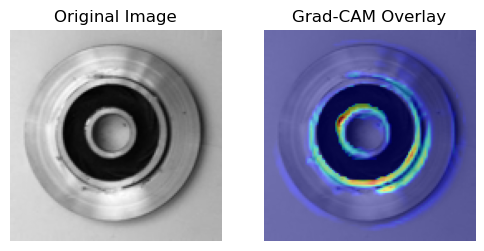

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()

## save the heatmap

In [136]:
plt.imsave("gradcam_overlay.jpg", heatmap, cmap='jet')

In [137]:
train_gen.class_indices

{'def_front': 0, 'ok_front': 1}

In [138]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


Dense(1, activation='sigmoid')

<Dense name=dense_14, built=False>

In [139]:
loss, accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {accuracy:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9972 - loss: 0.0082     
Test Accuracy: 0.9972


In [140]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_labels = (y_pred > 0.5).astype(int).reshape(-1)

print(confusion_matrix(y_true, y_pred_labels))
print(classification_report(y_true, y_pred_labels, target_names=['Defective', 'OK']))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
[[453   0]
 [  2 260]]
              precision    recall  f1-score   support

   Defective       1.00      1.00      1.00       453
          OK       1.00      0.99      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
✅ Prediction score: 0.9826
🧠 Predicted label: OK


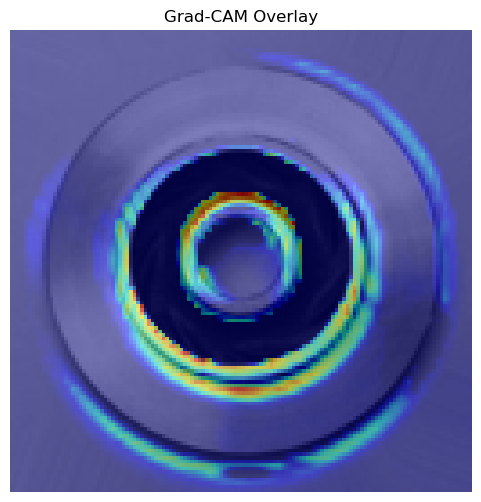

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image

# Load your trained model
model = tf.keras.models.load_model("cnn_model.h5")

# Grad-CAM function
def generate_gradcam(model, img_array, layer_name='conv2d_9'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (128, 128))
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()
    return heatmap

# Load and preprocess a single test image
img_path = r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\test\ok_front\cast_ok_0_904.jpeg"  # 🔁 Replace with actual path
img = Image.open(img_path).convert('L').resize((128, 128))
img_array = np.array(img).reshape(1, 128, 128, 1) / 255.0

# Predict
prediction_score = model.predict(img_array)[0][0]
predicted_label = int(round(prediction_score))

print(f"✅ Prediction score: {prediction_score:.4f}")
print(f"🧠 Predicted label: {'OK' if predicted_label == 1 else 'Defective'}")

# Grad-CAM visualization
heatmap = generate_gradcam(model, img_array)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
✅ Prediction score: 0.0000
🧠 Predicted label: Defective


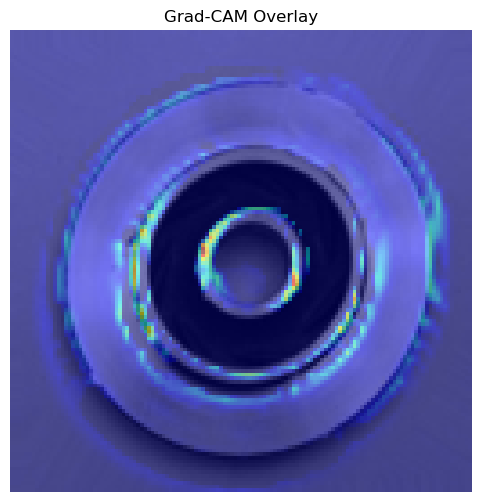

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image

# Load your trained model
model = tf.keras.models.load_model("cnn_model.h5")

# Grad-CAM function
def generate_gradcam(model, img_array, layer_name='conv2d_9'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = cv2.resize(cam, (128, 128))
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()
    return heatmap

# Load and preprocess a single test image
img_path = r"C:\Users\SANDEEP\Downloads\ML_EXAm\casting_data\test\def_front\cast_def_0_61.jpeg"  # 🔁 Replace with actual path
img = Image.open(img_path).convert('L').resize((128, 128))
img_array = np.array(img).reshape(1, 128, 128, 1) / 255.0

# Predict
prediction_score = model.predict(img_array)[0][0]
predicted_label = int(round(prediction_score))

print(f"✅ Prediction score: {prediction_score:.4f}")
print(f"🧠 Predicted label: {'OK' if predicted_label == 1 else 'Defective'}")

# Grad-CAM visualization
heatmap = generate_gradcam(model, img_array)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()